# Uncertainty and sensitivity analyses

Using the Sensitivity Analysis Library [SALib](https://salib.readthedocs.io/en/latest/) in Python.

In [1]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# From AeroMetric
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from climate_models.lwe_climate_model import species_lwe_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

# Sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Wrap metrics calculation in function

In [2]:
def climate_metric_parametric(species: str, metric: str, time_horizon_range: np.linspace, sensitivity_erf, ratio_erf_rf, efficacy_erf):
    """
    Function to calculate climate metrics for aviation emissions using different climate models and methods.
    :return: 
    """
    
    ### Fixed parameters
    #time_horizon = 100 # years
    #species = "Aviation contrails"
    unit_value = 1*10**10  # for contrails
    
    climate_model = "FaIR" # "GWP*", "LWE, "FaIR"
    co2_method = 'FaIR' # IPCC or FaIR
    profile = "pulse"
    if climate_model == "FaIR":
        start_year = 1765
    else:
        start_year = 2000
    t0 = 2020
    if climate_model == "GWP*" or climate_model == "LWE":
        tcre = 0.00045
    sensitivity_erf_co2 = 9.2e-16 # Not used with FaIR
    ratio_erf_rf_co2 = 1
    efficacy_erf_co2 = 1
    unit_value_co2 = 1*10**10

    ### Metric calculation for all time horizons
    time_horizon_range = range(20,110,10)
    metrics_dict = {
        'gwp_rf': np.zeros(len(time_horizon_range)),
        'gwp_erf': np.zeros(len(time_horizon_range)),
        'egwp_rf': np.zeros(len(time_horizon_range)),
        'egwp_erf': np.zeros(len(time_horizon_range)),
        'gtp': np.zeros(len(time_horizon_range)),
        'igtp': np.zeros(len(time_horizon_range)),
        'ratr': np.zeros(len(time_horizon_range)),          
    }
    k = 0
    for time_horizon in time_horizon_range:
        end_year = t0 + time_horizon
        if climate_model == "FaIR" or co2_method == "FaIR":
            background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')

        # CO2 metrics (absolute)
        emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, profile, unit_value_co2)
        if co2_method == 'IPCC':
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
        elif co2_method == 'FaIR':
            species_settings_co2 = {"sensitivity_erf": sensitivity_erf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}
            model_settings_co2 = {"background_species_quantities": background_species_quantities}
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
            radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
        
        # Species metrics (absolute)
        emission_profile = emission_profile_function(start_year,t0,time_horizon, profile, unit_value)
        if climate_model == "GWP*":
            species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_gwpstar_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "LWE":
            species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"tcre": tcre}
            radiative_forcing, effective_radiative_forcing, temperature = species_lwe_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        elif climate_model == "FaIR":
            species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
            model_settings = {"background_species_quantities": background_species_quantities}
            radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
        radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)

        # Species metrics (relative)
        metrics_dict['gwp_rf'][k], metrics_dict['gwp_erf'][k], metrics_dict['egwp_rf'][k], metrics_dict['egwp_erf'][k], metrics_dict['gtp'][k], metrics_dict['igtp'][k], metrics_dict['ratr'][k] = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
        
        k += 1
    
    return metrics_dict[metric]

In [3]:
climate_metric_parametric(species='Aviation contrails', metric='gwp_rf', time_horizon_range=np.arange(20, 110, 10), sensitivity_erf=9.36e-13, ratio_erf_rf=0.42, efficacy_erf=1.0)

array([90.81729967, 66.11039003, 52.82604625, 44.3732296 , 38.43046318,
       33.97478039, 30.51021162, 27.73457036, 25.44874629])

## 2. Uncertainty analysis

### a) Define problem

In [4]:
# Define problem
sp = ProblemSpec({
    'names': ['sensitivity_erf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        [2.8e-13, 1.6e-12], 
        [0.31, 0.59], 
        [0.12, 0.64]
    ],
    #'dists': ['unif', 'lognorm', 'triang'],
})

### b) Run analysis

In [6]:
# Create wrapper for function
species='Aviation contrails'
metric='gwp_rf'
time_horizon_range=np.arange(20,110,10)

def wrapped_model(params, species=species, metric=metric, time_horizon_range=time_horizon_range):
    n_samples = params.shape[0]
    n_times = time_horizon_range.shape[0]
    results = np.empty((n_samples, n_times))
    
    for i in range(n_samples):
        results[i, :] = climate_metric_parametric(
            species, 
            metric, 
            time_horizon_range, 
            *params[i]
        )
        
    return results

# Run all steps
nb_samples = 2
(
    sp.sample_sobol(nb_samples)  
    .evaluate(wrapped_model)
    .analyze_sobol()
)

/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.

Samples:
	3 parameters: ['sensitivity_erf', 'ratio_erf_rf', 'efficacy_erf']
	16 samples
Outputs:
	9 outputs: ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9']
	16 evaluations
Analysis:
Y1:
                       ST   ST_conf
sensitivity_erf  3.069555  5.450682
ratio_erf_rf     0.287104  1.355913
efficacy_erf     0.000000  0.000000:
                       S1   S1_conf
sensitivity_erf  2.021327  3.848597
ratio_erf_rf    -0.344639  1.036053
efficacy_erf     0.000000  0.000000:
                                       S2    S2_conf
(sensitivity_erf, ratio_erf_rf)  1.241843  14.878890
(sensitivity_erf, efficacy_erf) -0.327588   9.904741
(ratio_erf_rf, efficacy_erf)    -0.488288   5.185687:
Y2:
                       ST   ST_conf
sensitivity_erf  3.069555  6.036331
ratio_erf_rf     0.287104  1.505695
efficacy_erf     0.000000  0.000000:
                       S1   S1_conf
sensitivity_erf  2.021327  4.199321
ratio_erf_rf    -0.344639  1.139027
efficacy_erf     0.000000  0.000000:
         

### c) Plot

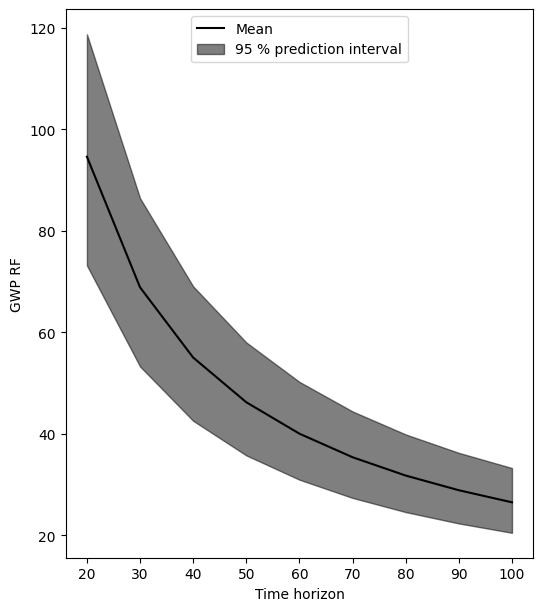

In [7]:
# Get first order sensitivities for all outputs
S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

# Get model outputs (each output is a given time horizon)
y = sp.results

# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(gs[:, 0])

ax0.plot(time_horizon_range, np.mean(y, axis=0), label="Mean", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(time_horizon_range,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("Time horizon")
ax0.set_ylabel(metric.upper().replace('_', ' '))
ax0.legend(loc='upper center')._legend_box.align = "left"

plt.show()

## 3. Sensitivity analyses (Sobol' indices)

In [8]:
def climate_metric_parametric(time_horizon, sensitivity_erf, ratio_erf_rf, efficacy_erf):
    """
    Function to calculate climate metrics for aviation emissions using different climate models and methods.
    :return: 
    """
    
    ### Fixed parameters
    #time_horizon = 100 # years
    species = "Aviation contrails"
    unit_value = 1*10**10  # for contrails
    
    climate_model = "FaIR" # "GWP*", "LWE, "FaIR"
    co2_method = 'FaIR' # IPCC or FaIR
    profile = "pulse"
    if climate_model == "FaIR":
        start_year = 1765
    else:
        start_year = 2000
    t0 = 2020
    if climate_model == "GWP*" or climate_model == "LWE":
        tcre = 0.00045
    end_year = t0 + time_horizon
    sensitivity_erf_co2 = 9.2e-16 # Not used with FaIR
    ratio_erf_rf_co2 = 1
    efficacy_erf_co2 = 1
    unit_value_co2 = 1*10**10
    
    ### Metric calculation
    if climate_model == "FaIR" or co2_method == "FaIR":
        background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
    
    # CO2 metrics (absolute)
    emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, profile, unit_value_co2)
    if co2_method == 'IPCC':
        agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
    elif co2_method == 'FaIR':
        species_settings_co2 = {"sensitivity_erf": sensitivity_erf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}
        model_settings_co2 = {"background_species_quantities": background_species_quantities}
        radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
        radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
        agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
        
    # Species metrics (absolute)
    emission_profile = emission_profile_function(start_year,t0,time_horizon, profile, unit_value)
    if climate_model == "GWP*":
        species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
        model_settings = {"tcre": tcre}
        radiative_forcing, effective_radiative_forcing, temperature = species_gwpstar_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    elif climate_model == "LWE":
        species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
        model_settings = {"tcre": tcre}
        radiative_forcing, effective_radiative_forcing, temperature = species_lwe_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    elif climate_model == "FaIR":
        species_settings = {"sensitivity_erf": sensitivity_erf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
        model_settings = {"background_species_quantities": background_species_quantities}
        radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
    agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
    
    # Species metrics (relative)
    gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)

    return gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr

In [9]:
# Single evaluation (test)
climate_metric_parametric(time_horizon=100, sensitivity_erf=9.36e-13, ratio_erf_rf=0.42, efficacy_erf=1.0)

(np.float64(25.448746292933343),
 np.float64(10.688473443032004),
 np.float64(10.688473443032004),
 np.float64(10.688473443032004),
 1.637605958391719,
 np.float64(12.07744898211559),
 np.float64(12.07744898211559))

In [10]:
# Define problem
sp = ProblemSpec({
    'names': ['sensitivity_erf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        [2.8e-13, 1.6e-12], 
        [0.31, 0.59], 
        [0.12, 0.64]
    ],
    #'dists': ['unif', 'lognorm', 'triang'],
    "outputs": ["gwp_rf", "gwp_erf", "egwp_rf", "egwp_erf", "gtp", "igtp", "ratr"],
})

# Create samples
sp.sample_sobol(4, calc_second_order=True)

# Create wrapper for function
time_horizon=100
def wrapped_func(X):
    return np.array([climate_metric_parametric(time_horizon, *row) for row in X])

# Run simulations
sp.evaluate(wrapped_func);

# Calculate sobol indices
sp.analyze_sobol(print_to_console=False, calc_second_order=True);

/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/miniconda3/envs/AeroMetrics/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.

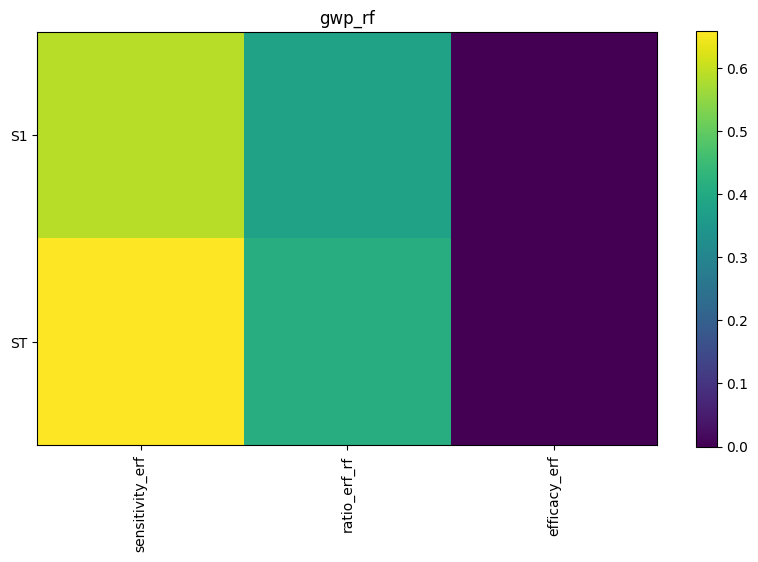

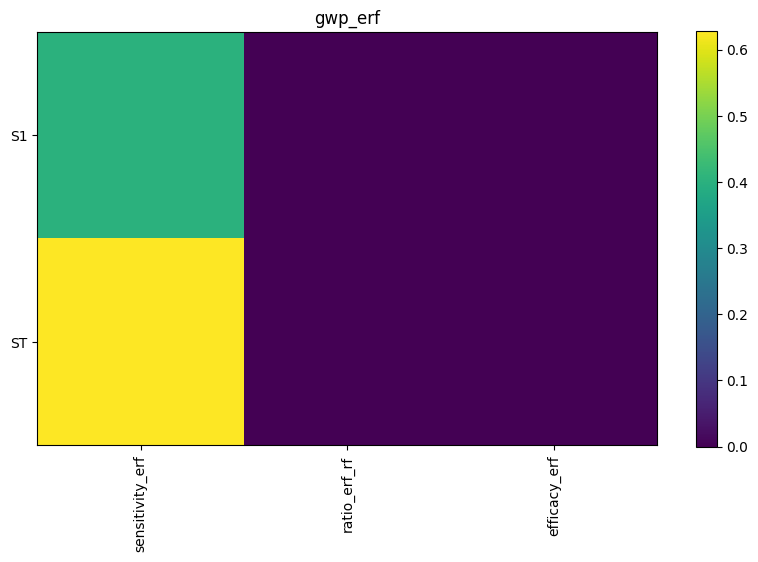

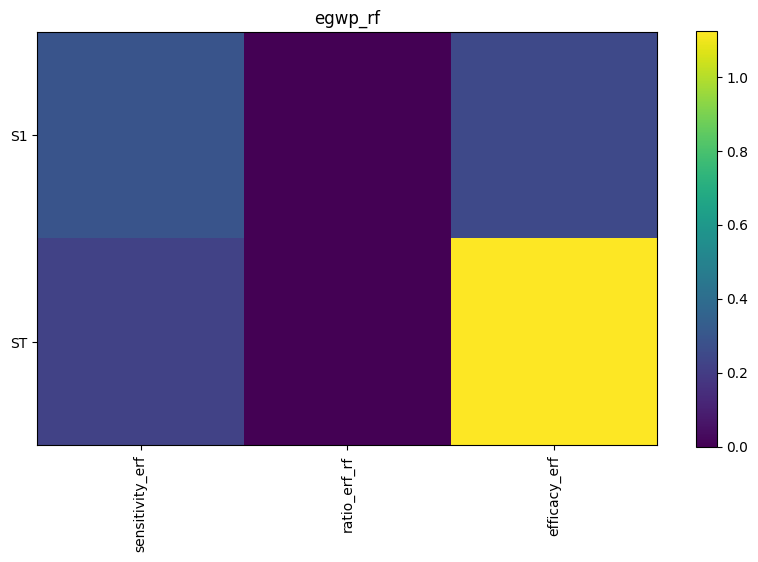

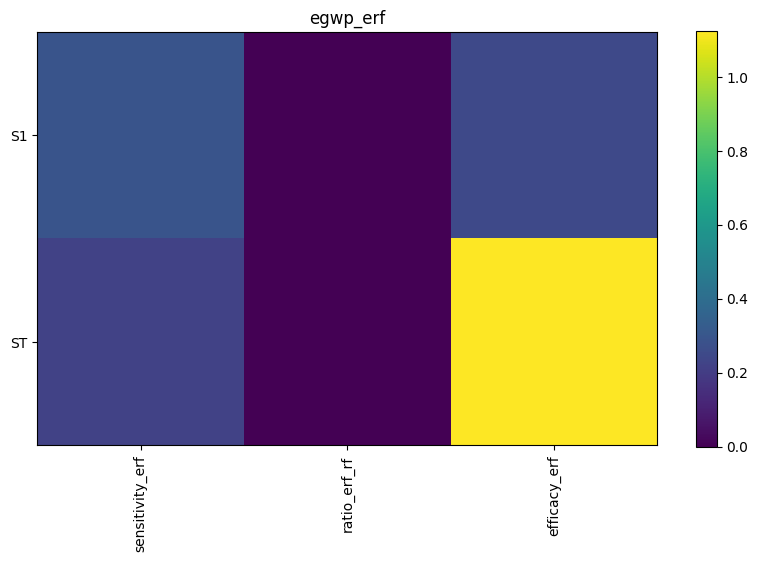

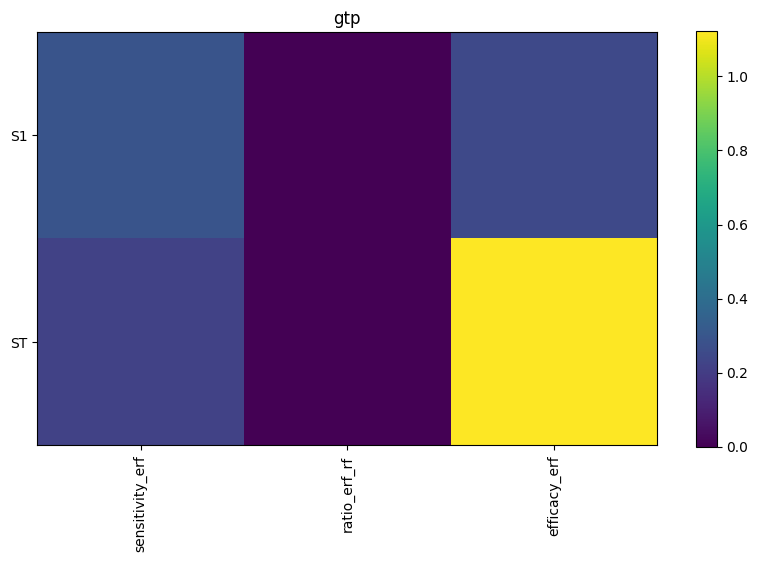

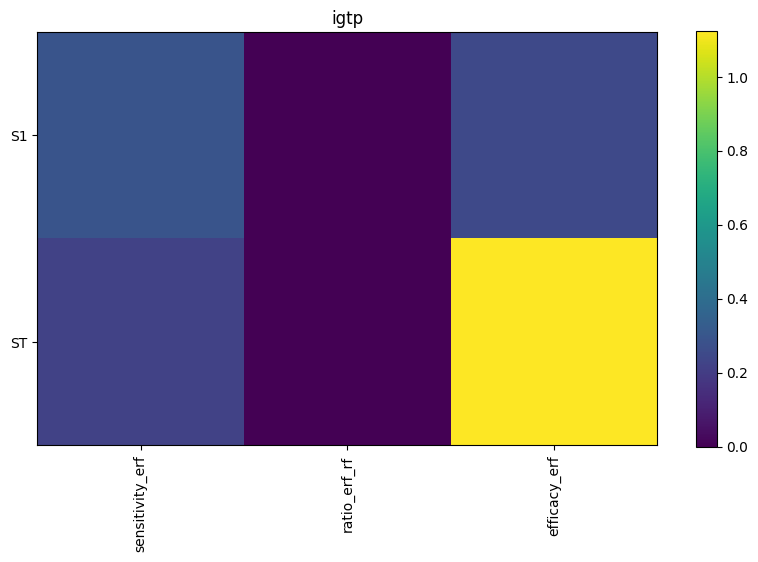

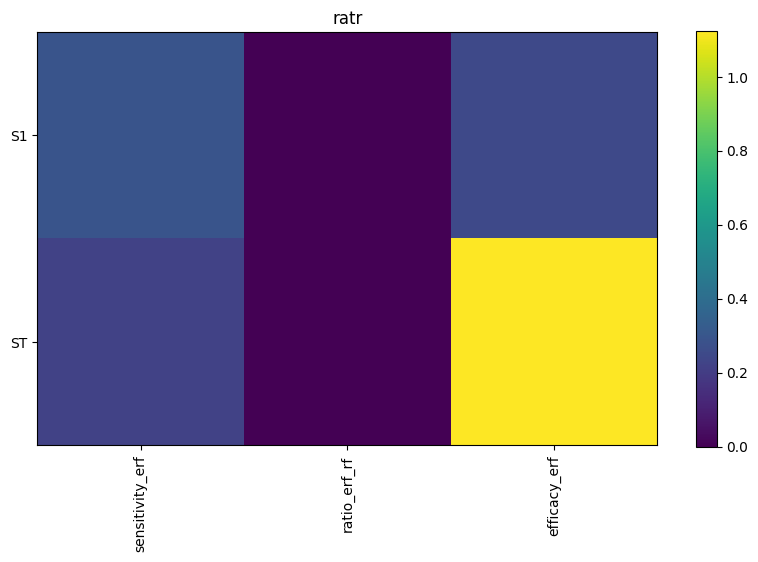

In [11]:
# Plot heatmaps
for output in sp["outputs"]:
    sp.heatmap(output)

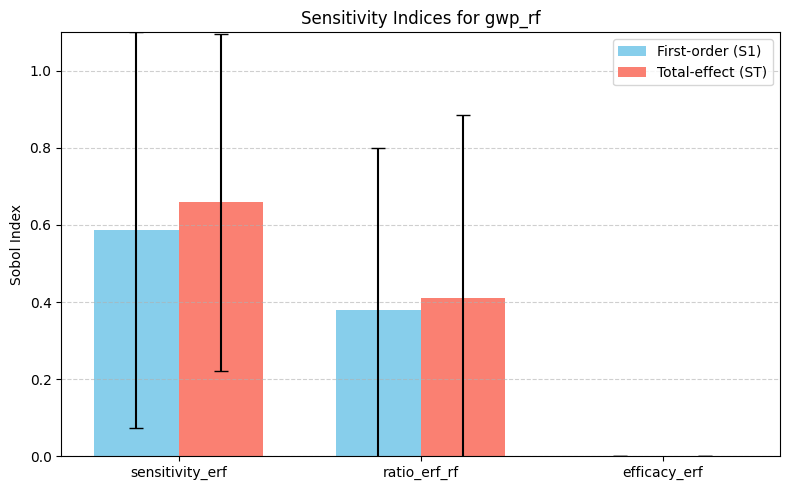

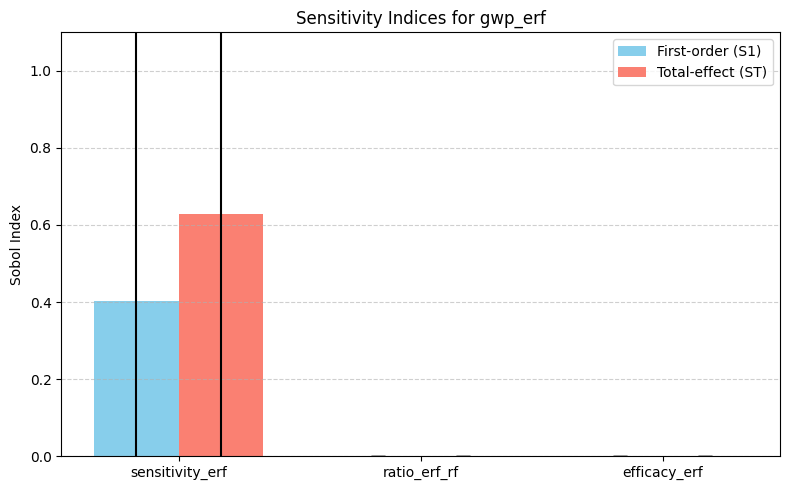

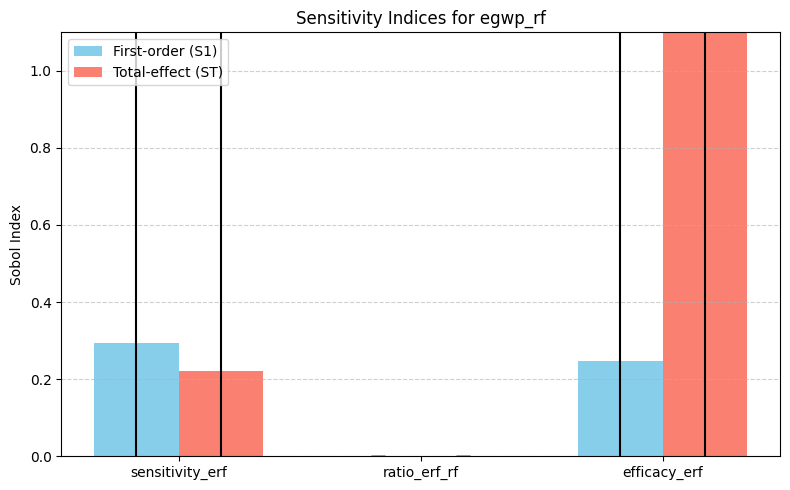

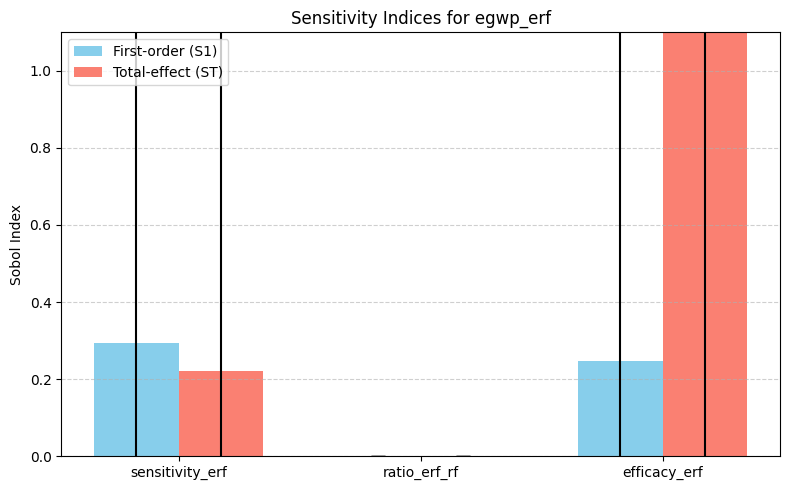

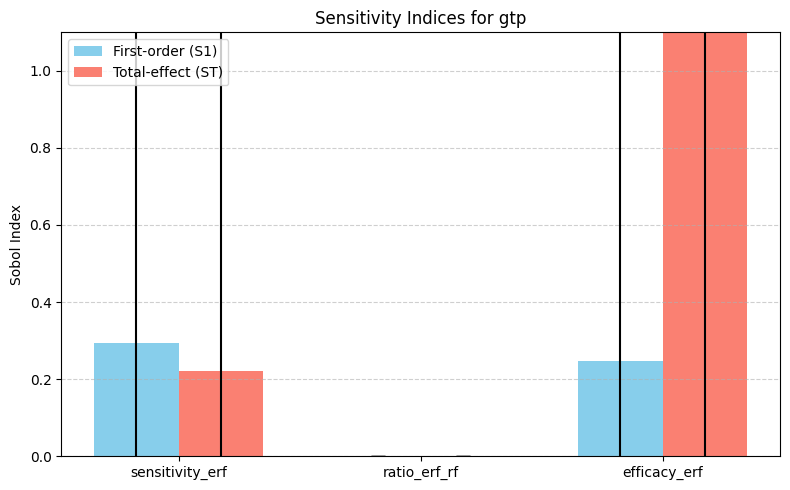

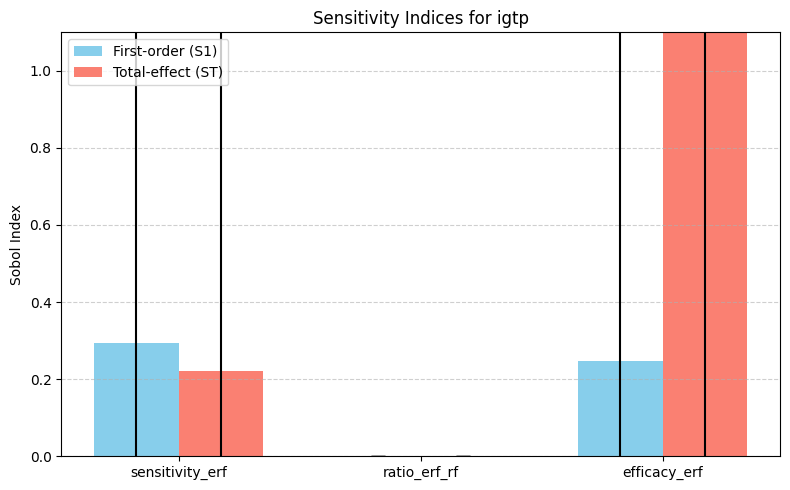

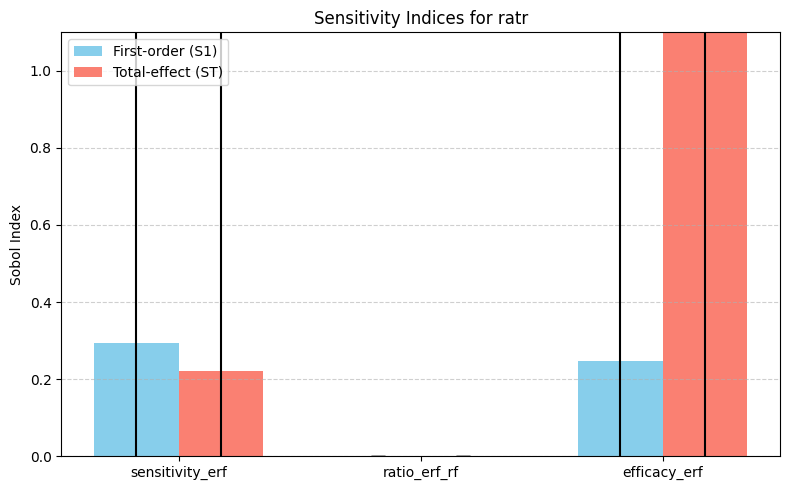

In [12]:
# Plot bars
names = sp["names"]
outputs = sp["outputs"]
analysis = sp.analysis

for i, output in enumerate(outputs):
    S1 = analysis[output]["S1"]
    S1_conf = analysis[output]["S1_conf"]
    ST = analysis[output]["ST"]
    ST_conf = analysis[output]["ST_conf"]

    x = np.arange(len(names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.bar(x - width/2, S1, width, yerr=S1_conf, capsize=5, label='First-order (S1)', color='skyblue')
    ax.bar(x + width/2, ST, width, yerr=ST_conf, capsize=5, label='Total-effect (ST)', color='salmon')

    ax.set_ylabel('Sobol Index')
    ax.set_title(f"Sensitivity Indices for {output}")
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim(0, 1.1)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()